In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, ZeroPadding2D, Add,add,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

In [3]:

dirname = ''
train_path = os.path.join(dirname, 'OCT2017/train')
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')
train_cnv_pth = os.path.join(train_path, 'CNV')
    
test_path = os.path.join(dirname, 'OCT2017/test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')
    
val_path = os.path.join(dirname, 'OCT2017/val')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')



In [4]:
def plot_imgs(item_dir, num_imgs=4):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 4, idx+1)

        img = cv2.imread(img_path,1)
        #img_eq = cv2.equalizeHist(img)

        plt.imshow(img)

    plt.tight_layout()

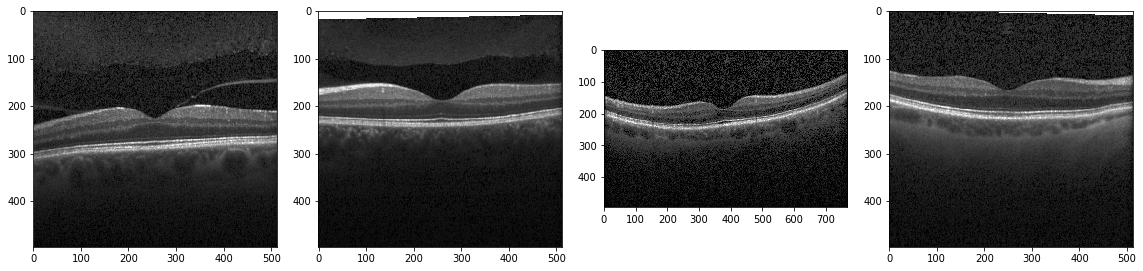

In [6]:
#NORMAL
plot_imgs(test_normal_pth)

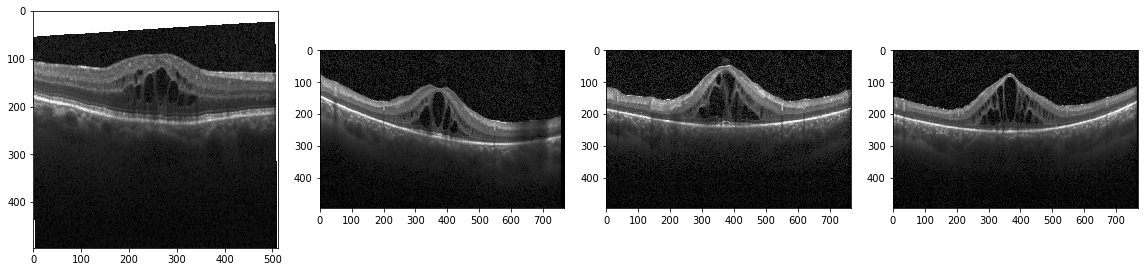

In [8]:
#DME
plot_imgs(test_dme_pth)

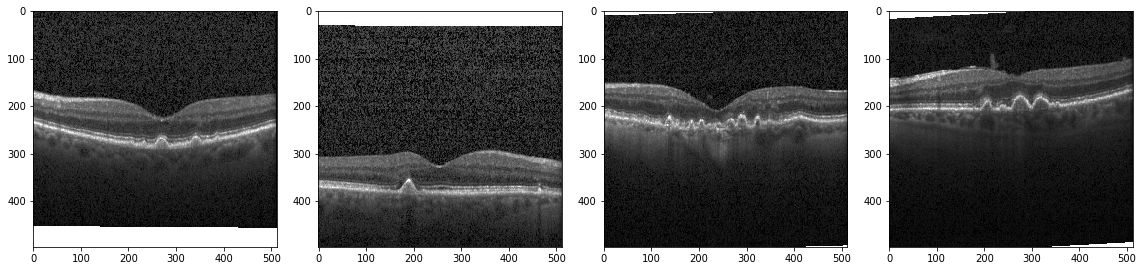

In [9]:
#DRUSEN
plot_imgs(test_drusen_pth)

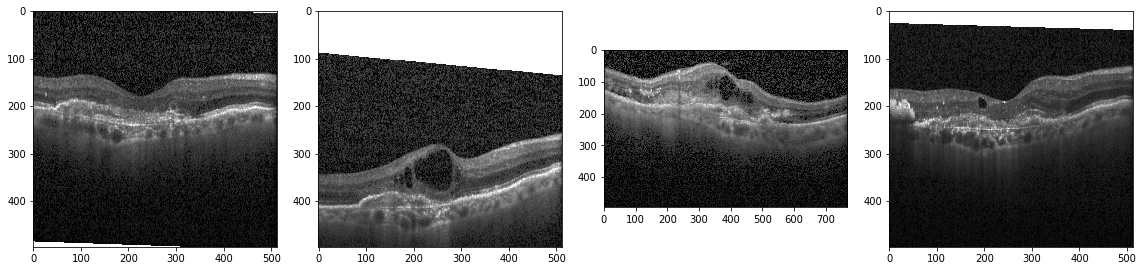

In [7]:

plot_imgs(test_cnv_pth)

In [10]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_width'] = max(width, data['max_height'])
        
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [11]:
Images_details(train_normal_pth)
Images_details(train_dme_pth)
Images_details(train_drusen_pth)
Images_details(train_cnv_pth)



 ====== Images in:  OCT2017/train\NORMAL
images_count:	26315
min_width:	384
max_width:	512
min_height:	496
max_height:	512
 ====== Images in:  OCT2017/train\DME
images_count:	11348
min_width:	512
max_width:	512
min_height:	496
max_height:	512
 ====== Images in:  OCT2017/train\DRUSEN
images_count:	8616
min_width:	512
max_width:	768
min_height:	496
max_height:	496
 ====== Images in:  OCT2017/train\CNV
images_count:	37205
min_width:	384
max_width:	1536
min_height:	496
max_height:	496


In [17]:
input_path = "OCT2017/"

for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

train, Normal images: 26315, DME images: 11348, DRUSEN images: 8616, CNV images: 37205
test, Normal images: 242, DME images: 242, DRUSEN images: 242, CNV images: 242
val, Normal images: 8, DME images: 8, DRUSEN images: 8, CNV images: 8


In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Invert(0.2),
        #iaa.Rotate((-45, 45)),
        #iaa.GaussianBlur(sigma=(0, 3.0)) 
        #iaa.Alpha((0.0, 1.0), iaa.AllChannelsHistogramEqualization())
        # blur images with a sigma of 0 to 3.0
    ])
def augment(img):
        seq_det = seq.to_deterministic()
        
        aug_image = seq_det.augment_image(img)
        return aug_image
    
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        horizontal_flip = True
        #preprocessing_function = augment 
    )
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=test_path, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
        for img in (os.listdir(test_path + cond)):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = np.dstack([img, img, img])
            
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/DME/':
                label = 1
            elif cond=='/DRUSEN/':
                label = 2
            elif cond=='/CNV/':
                label = 3
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [5]:
PARAMS = {'img_dims': 160,
          'epochs': 35,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }


In [6]:
#train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])


# Constant to control how often we print when training models
print_every = 100
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)
train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))


Using device:  /device:GPU:0
Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [7]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:


X = ZeroPadding2D((3,3))(inputs)
# First conv block
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPool2D((3, 3), strides=(2, 2))(X)


# Stage 2
X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
# Stage 3
X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

# Stage 4
X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

# Stage 5
X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

# AVGPOOL
X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
X = Flatten()(X)
X = Dense(4, activation='softmax')(X)

# Creating model and compiling
model = Model(inputs=inputs, outputs=X)
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=[PARAMS['metrics']])

# Callbacks

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
from sklearn.utils import class_weight

#train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])

#create class weights for unbalanced dataset
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))
history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
           epochs=PARAMS['epochs'],
           
           validation_data=test_gen, 
           validation_steps=test_gen.samples // PARAMS['batch_size'],
           class_weight = class_weights)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2608 steps, validate for 30 steps
Epoch 1/35
2608/2608 [==============================] - 619s 237ms/step - loss: 1.2488 - accuracy: 0.6299 - val_loss: 2.5362 - val_accuracy: 0.4385
Epoch 2/35
2608/2608 [==============================] - 614s 236ms/step - loss: 0.5319 - accuracy: 0.8222 - val_loss: 0.1474 - val_accuracy: 0.9333
Epoch 3/35
2608/2608 [==============================] - 613s 235ms/step - loss: 0.4108 - accuracy: 0.8701 - val_loss: 0.1676 - val_accuracy: 0.9198
Epoch 4/35
2608/2608 [==============================] - 613s 235ms/step - loss: 0.3350 - accuracy: 0.8918 - val_loss: 0.1677 - val_accuracy: 0.9583
Epoch 5/35
2608/2608 [==============================] - 614s 235ms/step - loss: 0.3016 - accuracy: 0.9013 - val_loss: 0.1124 - val_accuracy: 0.9792
Epoch 6/35
2608/2608 [==============================] - 614s 236ms/step - loss: 0.2779 - a

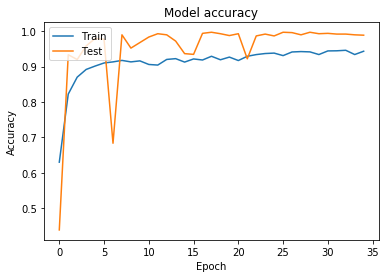

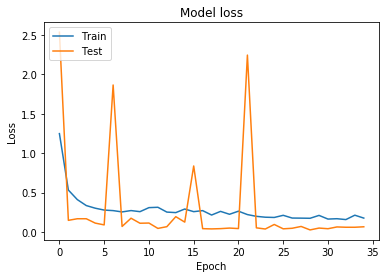

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
model.evaluate(test_gen)

  ...
    to  
  ['...']
31/31 [==============================] - 4s 120ms/step - loss: 0.0409 - accuracy: 0.9886


[0.04091925944592203, 0.9886364]

In [1]:
model.summary()

NameError: name 'model' is not defined